# PSP SPAN-Ion Velocity Distribution Function (VDF) Plotting Tutorial

Greetings! Below is a guide to plotting proton velocity-space distribution functions (VDFs) from the PSP SPAN-I instrument. If one is only interested in viewing a VDF at a particular time, the reader may skip to cell (blank).

We note that the SPAN-I instrument has many caveats and the data remains preliminary due to ongoing calibration work done by the instrument team. 

For optimal scientific interpretation of noteworthy event, the reader is strongly encouraged to contact a member of the instrument team:<br>
Roberto Livi rlivi@berkeley.edu <br>
Ali Rahmati rahmati@berkeley.edu <br>
Michael McManus mdmcmanus@berkeley.edu <br>
Davin Larson davin@berkeley.edu <br>

This tutorial was brought to you by: <br>
Jaye Verniero jaye.l.verniero@nasa.gov <br>
Kristoff Paulson kristoff.paulson@cfa.harvard.edu <br>
who may also serve as points of contact. <br>

A preprint describing the SPAN-I instrument in more detail can be found here: <br>https://www.essoar.org/doi/10.1002/essoar.10508651.1

This tutorial mirrors the SPAN-e plotting walkthrough found here: https://github.com/kpaulson/PSPGatewayHelp/blob/master/JupyterNotebook_Tutorials/PSP/SPANe_pitchAngleWalkthrough/PSP_SPANe_PitchAnglePlotter%20-%20PythonTutorial.ipynb
where the user can also learn about cdf files.

## Step 0

First, we import the cdf reader from spacepy (the library able to read the data encoded in the cdf format) and wget (which we will use here to grab and download the file from the remote server).

In [1]:

#from spacepy import pycdf 
#import spacepy.plot as splot
import wget
import numpy as np

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

## Step 1

Let's download the data!

In [2]:
#Import from file directory
VDfile_directoryRemote = 'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/2020/01/'
VDfile_filename = 'psp_swp_spi_sf00_L2_8Dx32Ex8A_20200129_v04.cdf'

import os.path

#check if file is already downloaded. If so, skip download. If not, download in local directory.
if os.path.isfile(VDfile_filename):
    print(f"File already exists in local directory - [{VDfile_filename}]") 
    VDfile = VDfile_filename
else:
    print("File doesn't exist. Downloading ...")
    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)

File already exists in local directory - [psp_swp_spi_sf00_L2_8Dx32Ex8A_20200129_v04.cdf]


Now, we open the cdf file and look at the variables along with their associated structure.

In [3]:
#open CDF file
#cdf_VDfile = pycdf.CDF(VDfile)

#print variable names in CDF files
import cdflib
dat = cdflib.CDF(VDfile)
#cdf_VDfile=cdflib.CDF(VDfile)
print(dat._get_varnames())
cdf_VDfile=dat
#check variable formats in cdf file
print(cdf_VDfile)

([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'DATA', 'GAP', 'QUALITY_FLAG', 'EFLUX', 'ENERGY', 'THETA', 'PHI', 'ROTMAT_SC_INST'])


## Step 2
Let's define some variables!

In [4]:
epoch           = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
rotMat          = cdf_VDfile['ROTMAT_SC_INST']

Type which timeslice you would like to plot in the format (year, month, day, hour, minute, second)

In [6]:
import datetime
# datetime(YYYY, mm, dd, HH, MM)
#start = datetime.datetime(2020, 1, 29, 18, 10,2)
#stop  = datetime.datetime(2020, 1, 29, 18, 10,2)
timeSlice  = datetime.datetime(2020, 1, 29, 18, 10,2)
print('Desired timeslice:',timeSlice)
#print('start of time period:',start)
#print('end of time period:',stop)
print('time slice:',timeSlice)
import bisect
#startIndex = bisect.bisect_left(epoch, start)
#stopIndex  = bisect.bisect_left(epoch, stop)
tSliceIndex  = bisect.bisect_left(epoch,timeSlice)
#print('startIndex:',startIndex)
#print('stopIndex:',stopIndex)
print('time Index:',tSliceIndex)
print('Time of closest data point:',epoch[tSliceIndex])

Desired timeslice: 2020-01-29 18:10:02
time slice: 2020-01-29 18:10:02


TypeError: '<' not supported between instances of 'int' and 'datetime.datetime'

Now define all variables at this time slice. 

In [30]:
epochSlice  = epoch[tSliceIndex]
thetaSlice  = theta[tSliceIndex,:]
phiSlice    = phi[tSliceIndex,:]
energySlice = energy[tSliceIndex,:]
efluxSlice  = eflux[tSliceIndex,:]

And now we rearrange to a more readable format reflecting 8 phi bins, 32 energy bins, and 8 theta bins. Note that the phi direction is partially obstructed by the heat shield, and therefore should be treated with extra caution (and ideally guidance from the instrument team).

In [36]:
thetaReshaped = thetaSlice.reshape((8,32,8))
phiReshaped = phiSlice.reshape((8,32,8))
energyReshaped = energySlice.reshape((8,32,8))
efluxReshaped = efluxSlice.reshape((8,32,8))

print(thetaReshaped.shape)

(8, 32, 8)


## Step 3
Now that we downloaded the data and defined the variables in the most optimal format, we are ready to begin our journey toward plotting a VDF.

In [37]:
mass_p = 0.010438870      #proton mass in units eV/c^2 where c = 299792 km/s
charge_p = 1              #proton charge in units eV

#Define VDF
numberFlux = efluxReshaped/energyReshaped
vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

#Convert to velocity units in each energy channel
vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

Next, rotate from energy-angle space to cartesian (vx,vy,vz) space (still in the SPAN-I instrument frame):

In [38]:
vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vz = vel *                                   np.sin(np.radians(thetaReshaped))

In [52]:

vdf_allAngles = np.sum(vdf, axis=(0,2))


print(vel.shape)
print(vdf_allAngles.shape)
print(vdf.shape)

import matplotlib.pyplot as plt

#thetaSlice = 3
plt.plot(vel[0,:,0],vdf_allAngles)
plt.yscale('log')

#import matplotlib.pyplot as plt
#from matplotlib import ticker, cm
#vdf_TEMP = np.mean(vdf, axis=(0))
#vx_TEMP = np.mean(vx, axis=(0))
#vz_TEMP = np.mean(vz, axis=(0))
#print(vdf_allAngles_TEMP.shape)
#print(vx.shape)
#print(vz.shape)

#fig,ax=plt.subplots()
#cs=ax.contourf(vx_TEMP, vz_TEMP, vdf_TEMP,locator=ticker.LogLocator(),cmap=cm.cool)
#cbar = fig.colorbar(cs)
#ax.set_xlim(-800,0)
#ax.set_ylim(-500,500)


(8, 32, 8)
(32,)
(8, 32, 8)
(8, 32, 8)
(8, 32, 8)


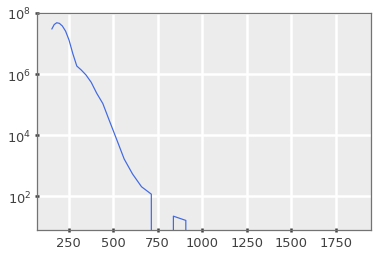

In [40]:
import matplotlib.pyplot as plt

thetaSlice = 3
plt.plot(vel[0,:,0],vdf_allAngles)
plt.yscale('log')


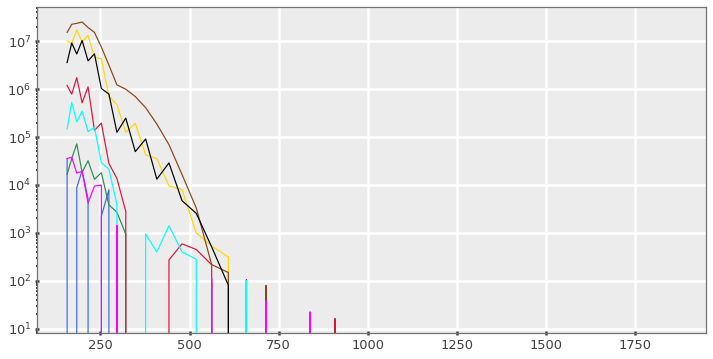

In [41]:

#plt.plot(vx_allEnergies[:,:],vdf_allEnergies[:,:])
#plt.yscale('log')
vdf_allThetas = np.sum(vdf, axis=0)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(vel[0,:,:],vdf_allThetas)

ax.set_yscale('log')
ax.set_xlim=(0,1000)



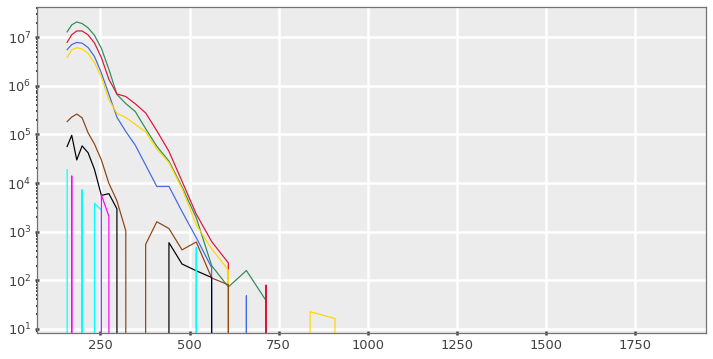

In [42]:
vdf_allPhis = np.sum(vdf, axis=2)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.transpose(vel[:,:,0]),np.transpose(vdf_allPhis))

ax.set_yscale('log')
ax.set_xlim=(0,1000)

In [43]:
print(vdf.shape)
print(vx.shape)

(8, 32, 8)
(8, 32, 8)


(32, 8)
(32, 8)
(32, 8)


<ipython-input-44-8eff6421777e>:27: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)


(-500.0, 500.0)

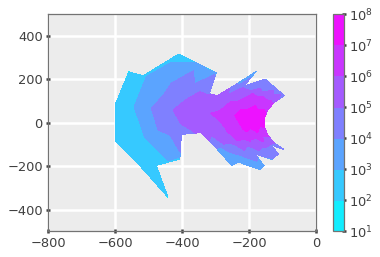

In [44]:
from matplotlib import ticker, cm

thetaplot_cut = 0
phiplot_cut = 2

#phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
#theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
#energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

phi_plane = phiReshaped[0,:,:]
theta_plane = thetaReshaped[0,:,:]
energy_plane = energyReshaped[0,:,:]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df=np.nansum(vdf,axis=thetaplot_cut)
print(df.shape)


vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

print(vx_plane.shape)
print(vy_plane.shape)

fig,ax=plt.subplots()
cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)




Now we can put it all together into a single plotting script where all we input is the timestamp:

In [45]:


def doitall(timeslice):

    from spacepy import pycdf 
    import spacepy.plot as splot
    import wget
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import ticker, cm
    import os.path
    
    year  = timeslice.year
    month = timeslice.month
    day   = timeslice.day
    
    if len(str(month)) < 2:
        month = '0'+str(month)


    from warnings import simplefilter 
    simplefilter(action='ignore', category=DeprecationWarning)

    #VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    #VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v03.cdf'
    
    #This will be a terrible way to do this, but it should at least work (for a while, anyway)
    versionList = ['09', '08', '07', '06', '05', '04', '03', '02', '01', '00']

    versionTest = 'notFound'
    for version in versionList:
        if versionTest == 'notFound':
            VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
            VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v{version}.cdf'
            
            
            if os.path.isfile(VDfile_filename):
                print("Version {version} exists")
                VDfile = VDfile_filename
                versionTest = 'found'
            else:
                try:
                    #print(f"Version {version} doesn't exist locally, searching online..")
                    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)
                    versionTest = 'found'
                    print(f'Grabbed version {version}')
                except:
                    continue
        elif versionTest == 'found':
            break

    cdf_VDfile = pycdf.CDF(VDfile)

    epoch           = cdf_VDfile['Epoch']
    theta           = cdf_VDfile['THETA']
    phi             = cdf_VDfile['PHI']
    energy          = cdf_VDfile['ENERGY']
    eflux           = cdf_VDfile['EFLUX']
    rotMat          = cdf_VDfile['ROTMAT_SC_INST']

    print('Desired timeslice:',timeslice)
    import bisect
    tSliceIndex  = bisect.bisect_left(epoch, timeslice)
    print('time Index:',tSliceIndex)
    print('Time of closest data point:',epoch[tSliceIndex])

    epochSlice  = epoch[tSliceIndex]
    thetaSlice  = theta[tSliceIndex,:]
    phiSlice    = phi[tSliceIndex,:]
    energySlice = energy[tSliceIndex,:]
    efluxSlice  = eflux[tSliceIndex,:]

    thetaReshaped = thetaSlice.reshape((8,32,8))
    phiReshaped = phiSlice.reshape((8,32,8))
    energyReshaped = energySlice.reshape((8,32,8))
    efluxReshaped = efluxSlice.reshape((8,32,8))

    mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
    charge_p = 1              #eV

    #Define VDF
    numberFlux = efluxReshaped/energyReshaped
    vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

    #Convert to velocity units in each energy channel
    vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel *                                   np.sin(np.radians(thetaReshaped))


    thetaplot_cut = 0
    phiplot_cut = 2

    #phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
    #theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
    #energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

    phi_plane = phiReshaped[0,:,:]
    theta_plane = thetaReshaped[0,:,:]
    energy_plane = energyReshaped[0,:,:]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df=np.nansum(vdf,axis=thetaplot_cut)
    

    vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

    fig,ax=plt.subplots()
    cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
    cbar = fig.colorbar(cs)
    ax.set_xlim(-800,0)
    ax.set_ylim(-500,500)
    ax.set_title(epoch[tSliceIndex].isoformat(timespec='seconds'))



Version {version} exists
Desired timeslice: 2020-01-29 18:10:02
time Index: 9355
Time of closest data point: 2020-01-29 18:10:02.709164


<ipython-input-45-6d276a5638df>:111: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)


Grabbed version 03
Desired timeslice: 2021-01-20 03:47:08
time Index: 3899
Time of closest data point: 2021-01-20 03:47:10.368559


<ipython-input-45-6d276a5638df>:111: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)


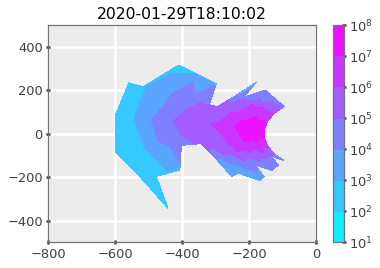

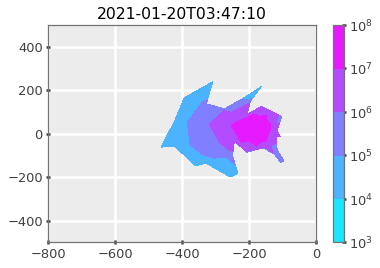

In [46]:

import datetime
# datetime(YYYY, mm, dd, HH, MM)
timeSlice  = datetime.datetime(2020, 1, 29, 18, 10, 2)   # Original test slice
#timeSlice  = datetime.datetime(2021, 1, 20, 2, 14, 31)   

doitall(timeSlice)
#timeSlice  = datetime.datetime(2021, 1, 20, 4, 57, 38)   # Period of high trat?
timeSlice  = datetime.datetime(2021, 1, 20, 3, 47, 8)   # Period of high trat?
doitall(timeSlice)

In [47]:


def doitallRange(timeStart, timeEnd):

    from spacepy import pycdf 
    import spacepy.plot as splot
    import wget
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import ticker, cm
    import os.path
    
    timeslice = timeStart
    
    year  = timeslice.year
    month = timeslice.month
    day   = timeslice.day
    
    if len(str(month)) < 2:
        month = '0'+str(month)


    from warnings import simplefilter 
    simplefilter(action='ignore', category=DeprecationWarning)

    #VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    #VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v03.cdf'
    
    #This will be a terrible way to do this, but it should at least work (for a while, anyway)
    versionList = ['09', '08', '07', '06', '05', '04', '03', '02', '01', '00']

    versionTest = 'notFound'
    for version in versionList:
        if versionTest == 'notFound':
            VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
            VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v{version}.cdf'
            
            
            if os.path.isfile(VDfile_filename):
                print("Version {version} exists")
                VDfile = VDfile_filename
                versionTest = 'found'
            else:
                try:
                    #print(f"Version {version} doesn't exist locally, searching online..")
                    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)
                    versionTest = 'found'
                    print(f'Grabbed version {version}')
                except:
                    continue
        elif versionTest == 'found':
            break

    cdf_VDfile = pycdf.CDF(VDfile)

    epoch           = cdf_VDfile['Epoch']
    theta           = cdf_VDfile['THETA']
    phi             = cdf_VDfile['PHI']
    energy          = cdf_VDfile['ENERGY']
    eflux           = cdf_VDfile['EFLUX']
    rotMat          = cdf_VDfile['ROTMAT_SC_INST']

    print('Desired timerange:',timeStart, ' to ', timeEnd)
    import bisect
    tSliceIndex_start  = bisect.bisect_left(epoch, timeStart)
    tSliceIndex_end    = bisect.bisect_right(epoch, timeEnd)
    tSliceIndex = tSliceIndex_start+int((tSliceIndex_end-tSliceIndex_start)/2.)
    print('time Index Start:',tSliceIndex_start)
    print('time Index End:',tSliceIndex_end)
    print('Time of closest start data point:',epoch[tSliceIndex_start])
    print('Time of closest end data point:',epoch[tSliceIndex_end])

    print(timeEnd - timeStart)
    epochSlice  = epoch[tSliceIndex]
    print(epochSlice)
    thetaSlice  = theta[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    phiSlice    = phi[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    energySlice = energy[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    efluxSlice  = eflux[tSliceIndex_start:tSliceIndex_end].mean(axis=0)

    thetaReshaped = thetaSlice.reshape((8,32,8))
    phiReshaped = phiSlice.reshape((8,32,8))
    energyReshaped = energySlice.reshape((8,32,8))
    efluxReshaped = efluxSlice.reshape((8,32,8))

    mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
    charge_p = 1              #eV

    #Define VDF
    numberFlux = efluxReshaped/energyReshaped
    vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

    #Convert to velocity units in each energy channel
    vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel *                                   np.sin(np.radians(thetaReshaped))


    thetaplot_cut = 0
    phiplot_cut = 2

    #phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
    #theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
    #energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

    phi_plane = phiReshaped[0,:,:]
    theta_plane = thetaReshaped[0,:,:]
    energy_plane = energyReshaped[0,:,:]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df=np.nansum(vdf,axis=thetaplot_cut)
    

    vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

    fig,ax=plt.subplots()
    cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)
    cbar = fig.colorbar(cs)
    ax.set_xlim(-800,0)
    ax.set_ylim(-500,500)
    ax.set_title(str(epoch[tSliceIndex].isoformat(timespec='seconds'))+f' +/- {(timeEnd - timeStart)}')



Version {version} exists
Desired timerange: 2021-01-20 02:14:30  to  2021-01-20 02:14:40
time Index Start: 2309
time Index End: 2312
Time of closest start data point: 2021-01-20 02:14:32.901415
Time of closest end data point: 2021-01-20 02:14:43.387196
0:00:10
2021-01-20 02:14:36.396655


<ipython-input-47-ef48d9a400dc>:119: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)


Version {version} exists
Desired timerange: 2021-01-20 03:48:00  to  2021-01-20 03:48:10
time Index Start: 3914
time Index End: 3917
Time of closest start data point: 2021-01-20 03:48:02.797526
Time of closest end data point: 2021-01-20 03:48:13.283308
0:00:10
2021-01-20 03:48:06.292767


<ipython-input-47-ef48d9a400dc>:119: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)


Version {version} exists
Desired timerange: 2021-01-20 05:00:00  to  2021-01-20 05:00:10
time Index Start: 5150
time Index End: 5153
Time of closest start data point: 2021-01-20 05:00:02.941660
Time of closest end data point: 2021-01-20 05:00:13.427442
0:00:10
2021-01-20 05:00:06.436901


<ipython-input-47-ef48d9a400dc>:119: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)


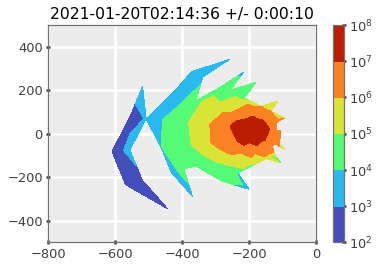

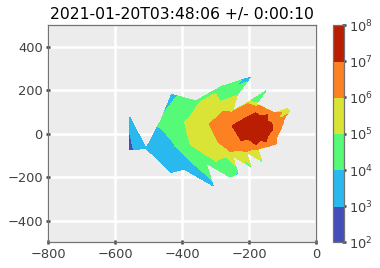

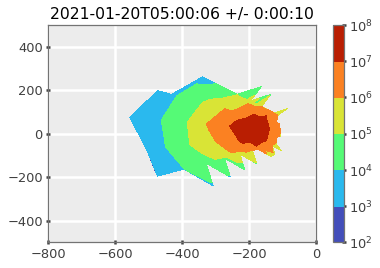

In [48]:

import datetime
# datetime(YYYY, mm, dd, HH, MM)
#timeSlice  = datetime.datetime(2020, 1, 29, 18, 10, 2)   # Original test slice

timeStart  = datetime.datetime(2021, 1, 20, 2, 14, 30)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)

timeStart  = datetime.datetime(2021, 1, 20, 3, 48, 0)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)

timeStart  = datetime.datetime(2021, 1, 20, 5, 0, 0)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)


#timeStart  = datetime.datetime(2020, 1, 29, 20, 30, 0)  
#timeEnd  = timeStart + datetime.timedelta(seconds=10)
#doitallRange(timeStart, timeEnd)


#timeStart  = datetime.datetime(2020, 1, 29, 21, 0, 0)  
#timeEnd  = timeStart + datetime.timedelta(seconds=10)
#doitallRange(timeStart, timeEnd)